### Bloomfield demand correlations ###

Exploring the correlations between some of Hannah's older datasets which include demand (hopefully in some kind of GW/GWh unit) to explore the relationship between climate indices and electricity demand.

Goal is to move towards a space where we have some quantification of UK demand (in GW/GWh) which we can predict to some capacity, along with UK offshore wind power CF.'s (in GW/GWh, which we know we can predict using delta P), to quantify a time series of demand-net-wind (demand - wind) to explore whether this is something we can predict on decadal timescales.

In [1]:
# Local libraries
import os
import sys
import glob

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from scipy import signal

In [2]:
# Show the directory in which the files are stored
dir = "/home/users/benhutch/ERA5_energy_update"

# LIst the files in this directory
os.listdir(dir)

['README_ERA5_reanalysis_models.txt',
 'ERA5_CDD_1979_2018.csv',
 'ERA5_T2m_1979_2018.csv',
 'ERA5_full_demand_1979_2018.csv',
 'ERA5_HDD_1979_2018.csv',
 'ERA5_Regression_coeffs_demand_model.csv',
 'ERA5_weather_dependent_demand_1979_2018.csv',
 'ERA5_T2m_all_countries_1979_2018_inclusive_3hourly.csv',
 'ERA5_solar_power_capacity_factor_all_countries_1979_2018_inclusive_3hourly.csv',
 'ERA5_SWGDN_all_countries_1979_2018_inclusive_3hourly.csv',
 'Enercon_E70_2300MW_turbine.csv',
 'ERA5_wind_power_capacity_factor_all_countries_1979_2018_inclusive_3hourly.csv',
 'ERA5_whh_all_countries_1979_2018_inclusive_3hourly.csv',
 'Vestas_v110_2000MW_turbine.csv',
 'Gamesa_G87_2000MW_turbine.csv',
 'ERA5_full_demand_1979_2018_8yrRM_ONDJFM.csv',
 'ERA5_weather_dependent_demand_1979_2018_8yrRM_ONDJFM.csv']

### Demand data ###

* *ERA5_full_demand_1979_2018.csv* - Daily mean country level electricity demand for the 28 countries modelled in this study from 01/01/1979 to 31/12/2018.   
* *ERA5_weather_dependent_demand_1979_2018.csv* - Daily mean country level electricity weather-dependent demand for the 28 countries modelled in this study from 01/01/1979 to 31/12/2018.

#### Demand model ####

A time series of daily mean electricity demand for 28 European countries was derived from 2m temperature (T2m) data from the ERA5 reanalysis. The model was developed on a daily resolution using a multiple-linear regression model where the possible model inputs are the day of the week, heating degree days (HDD) and cooling degree days (CDD). The model is optimised to choose the best set of parameters to minimise the Akaike information criteria. Time-series of the weather-dependent model input parameters (T2m, HDD, CDD) are available as well as the full demand model output and weather-dependent demand (i.e. the demand with the effects of the day of the week removed by setting those regression coefficients to zero).

In [3]:
# Load in the demand data
full_demand_fname = "ERA5_full_demand_1979_2018.csv"
full_demand_wdependent_fname = "ERA5_weather_dependent_demand_1979_2018.csv"

# Load in the demand data
full_demand = pd.read_csv(os.path.join(dir, full_demand_fname))

# Load in the demand data
full_demand_weather = pd.read_csv(os.path.join(dir, full_demand_wdependent_fname))

In [4]:
full_demand.head()

,Unnamed: 0,Austria_full_demand_no_pop_weights_1979_2018.dat,Belgium_full_demand_no_pop_weights_1979_2018.dat,Bulgaria_full_demand_no_pop_weights_1979_2018.dat,Croatia_full_demand_no_pop_weights_1979_2018.dat,Czech_Republic_full_demand_no_pop_weights_1979_2018.dat,Denmark_full_demand_no_pop_weights_1979_2018.dat,Finland_full_demand_no_pop_weights_1979_2018.dat,France_full_demand_no_pop_weights_1979_2018.dat,Germany_full_demand_no_pop_weights_1979_2018.dat,...,Norway_full_demand_no_pop_weights_1979_2018.dat,Poland_full_demand_no_pop_weights_1979_2018.dat,Portugal_full_demand_no_pop_weights_1979_2018.dat,Romania_full_demand_no_pop_weights_1979_2018.dat,Slovakia_full_demand_no_pop_weights_1979_2018.dat,Slovenia_full_demand_no_pop_weights_1979_2018.dat,Spain_full_demand_no_pop_weights_1979_2018.dat,Sweden_full_demand_no_pop_weights_1979_2018.dat,Switzerland_full_demand_no_pop_weights_1979_2018.dat,United_Kingdom_full_demand_no_pop_weights_1979_2018.dat
0,"('1979-01-01',)",8.605480,13.073229,4.480123,2.056981,9.796862,4.721153,12.956948,83.835412,64.081609,...,25.146248,22.518053,5.968007,7.063165,3.787129,1.538655,29.685064,23.744467,7.870762,49.833379
1,"('1979-01-02',)",9.491813,12.498014,5.557895,2.349787,9.788056,4.681681,13.114426,87.320377,65.425365,...,23.944521,22.408836,6.196767,8.219921,4.005506,1.725943,30.824693,23.068526,8.423941,47.996807
2,"('1979-01-03',)",9.443403,12.691651,6.347009,2.380751,9.606212,4.688280,13.146203,85.420152,64.623033,...,24.518593,22.347208,6.158716,8.420241,3.977617,1.768301,30.861329,23.994230,8.289964,47.691554
3,"('1979-01-04',)",9.500878,12.419853,6.255989,2.310251,9.650421,4.763490,13.309447,78.860953,65.101535,...,24.663098,22.999755,6.383213,8.368188,3.973771,1.740730,30.850026,24.785046,8.244870,47.716700
4,"('1979-01-05',)",9.448862,12.715883,5.680840,2.293173,9.592209,4.572931,13.256528,79.499146,63.893510,...,23.663964,22.140660,6.581421,8.250280,3.989685,1.711654,31.083201,24.516887,8.098996,48.190215


In [5]:
# restrict to column United_Kingdom_full_demand_no_pop_weights_1979_2018.dat
# and Unnamed: 0
full_demand = full_demand[['Unnamed: 0', 'United_Kingdom_full_demand_no_pop_weights_1979_2018.dat']]


In [6]:
full_demand.head()

,Unnamed: 0,United_Kingdom_full_demand_no_pop_weights_1979_2018.dat
0,"('1979-01-01',)",49.833379
1,"('1979-01-02',)",47.996807
2,"('1979-01-03',)",47.691554
3,"('1979-01-04',)",47.716700
4,"('1979-01-05',)",48.190215


In [7]:
# rename Unnamed: 0	as date
full_demand.rename(columns = {'Unnamed: 0':'date'}, inplace = True)

# rename United_Kingdom_full_demand_no_pop_weights_1979_2018.dat
# as UK_demand (GW)
full_demand.rename(columns = {'United_Kingdom_full_demand_no_pop_weights_1979_2018.dat':'UK_demand (GW)'}, inplace = True)

In [8]:
full_demand.head()

,date,UK_demand (GW)
0,"('1979-01-01',)",49.833379
1,"('1979-01-02',)",47.996807
2,"('1979-01-03',)",47.691554
3,"('1979-01-04',)",47.716700
4,"('1979-01-05',)",48.190215


In [9]:
# if date is now 	('1979-01-01',)
# strip out YYYY-MM-DD and convert to datetime
# remove the brackets
full_demand['date'] = full_demand['date'].str[2:-3]

# convert to datetime
full_demand['date'] = pd.to_datetime(full_demand['date'])

In [10]:
full_demand.head()

,date,UK_demand (GW)
0,1979-01-01,49.833379
1,1979-01-02,47.996807
2,1979-01-03,47.691554
3,1979-01-04,47.716700
4,1979-01-05,48.190215


In [11]:
# process for ONDJFM 8yrRM
# Set the date as the index
full_demand.set_index('date', inplace=True)

# Take monthly averages
full_demand_monthly = full_demand.resample('M').mean()

# Set up the months of interest
ondjfm_months = [10, 11, 12, 1, 2, 3]

# Select only the months of interest
full_demand_ondjfm = full_demand_monthly[full_demand_monthly.index.month.isin(ondjfm_months)]

# Remove the first 3 and last 3 months
full_demand_ondjfm = full_demand_ondjfm[3:-3]

# Take the annual mean
full_demand_ondjfm_8yrRM = full_demand_ondjfm.resample('A').mean()

# Take the 8-year rolling mean
full_demand_ondjfm_8yrRM = full_demand_ondjfm_8yrRM.rolling(window=8, center=True).mean()

In [12]:
# Set month back to a column
full_demand_ondjfm_8yrRM.reset_index(inplace=True)

In [13]:
full_demand_ondjfm_8yrRM.head()

,date,UK_demand (GW)
0,1979-12-31,NaN
1,1980-12-31,NaN
2,1981-12-31,NaN
3,1982-12-31,NaN
4,1983-12-31,41.11236


In [14]:
# set up a filename
fname = "ERA5_full_demand_1979_2018_8yrRM_ONDJFM.csv"

# save the file
full_demand_ondjfm_8yrRM.to_csv(os.path.join(dir, fname), index=False)

In [15]:
# full_demand_weather.columns

In [16]:
# now for full_demand_weather
# restrict to column United_Kingdom_full_demand_no_pop_weights_1979_2018.dat and Unnamed: 0
full_demand_weather = full_demand_weather[['Unnamed: 0', 'United_Kingdom_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat']]

# rename Unnamed: 0	as date
full_demand_weather.rename(columns = {'Unnamed: 0':'date'}, inplace = True)

# rename United_Kingdom_full_demand_no_pop_weights_1979_2018.dat as UK_demand (GW)
full_demand_weather.rename(columns = {'United_Kingdom_wd_demand_no_pop_weights_no_time_trend_1979_2018.dat':'UK_wd_demand (GW)'}, inplace = True)

# convert date to datetime
full_demand_weather['date'] = pd.to_datetime(full_demand_weather['date'])

# Set the date as the index
full_demand_weather.set_index('date', inplace=True)

In [17]:
# Take monthly averages
full_demand_weather_monthly = full_demand_weather.resample('M').mean()

# Select only the months of interest
full_demand_weather_ondjfm = full_demand_weather_monthly[full_demand_weather_monthly.index.month.isin(ondjfm_months)]

# Remove the first 3 and last 3 months
full_demand_weather_ondjfm = full_demand_weather_ondjfm[3:-3]

# Take the annual mean
full_demand_weather_ondjfm_8yrRM = full_demand_weather_ondjfm.resample('A').mean()

# Take the 8-year rolling mean
full_demand_weather_ondjfm_8yrRM = full_demand_weather_ondjfm_8yrRM.rolling(window=8, center=True).mean()

# Set month back to a column
full_demand_weather_ondjfm_8yrRM.reset_index(inplace=True)

In [18]:
full_demand_weather_ondjfm_8yrRM.head()

,date,UK_wd_demand (GW)
0,1979-12-31,NaN
1,1980-12-31,NaN
2,1981-12-31,NaN
3,1982-12-31,NaN
4,1983-12-31,42.575086


In [19]:
# Set up a filename
fname = "ERA5_weather_dependent_demand_1979_2018_8yrRM_ONDJFM.csv"

# Save the file
full_demand_weather_ondjfm_8yrRM.to_csv(os.path.join(dir, fname), index=False)

In [20]:
print(dir)

/home/users/benhutch/ERA5_energy_update


In [21]:
# join the two dataframes
UK_demand = pd.merge(full_demand_ondjfm_8yrRM, full_demand_weather_ondjfm_8yrRM, on='date')

In [22]:
UK_demand.head()

,date,UK_demand (GW),UK_wd_demand (GW)
0,1979-12-31,NaN,NaN
1,1980-12-31,NaN,NaN
2,1981-12-31,NaN,NaN
3,1982-12-31,NaN,NaN
4,1983-12-31,41.11236,42.575086


In [23]:
# merge with climate indices demand to look at decadal correlations
path = "/home/users/benhutch/NGrid_demand/csv_files/climate_indices_demand.csv"

# load in the climate indices demand data
climate_indices_demand = pd.read_csv(
    path,
)

In [24]:
climate_indices_demand.head()

,date,NAO anomaly (Pa),delta P anomaly (Pa),UK_temp_anomaly,elec_demand_5yrRmean,elec_demand_5yrRmean_nohols,gas_demand_5yrRmean,gas_demand_5yrRmean_nohols,gas_demand_raw
0,1964-12-31,-459.574041,-266.863413,4.910844,NaN,NaN,NaN,NaN,NaN
1,1965-12-31,-690.520941,-402.505753,4.787535,NaN,NaN,NaN,NaN,NaN
2,1966-12-31,-668.601591,-396.281847,4.835569,NaN,NaN,NaN,NaN,NaN
3,1967-12-31,-603.603464,-311.324045,5.176834,NaN,NaN,NaN,NaN,NaN
4,1968-12-31,-487.695747,-261.748211,5.318128,NaN,NaN,NaN,NaN,NaN


In [25]:
# Ensure that date is in datetime format
climate_indices_demand['date'] = pd.to_datetime(climate_indices_demand['date'])

# Join the two dataframes
climate_indices_demand = climate_indices_demand.merge(UK_demand, on='date', how='left')

In [38]:
climate_indices_demand.tail()

,date,NAO anomaly (Pa),delta P anomaly (Pa),UK_temp_anomaly,elec_demand_5yrRmean,elec_demand_5yrRmean_nohols,gas_demand_5yrRmean,gas_demand_5yrRmean_nohols,gas_demand_raw,UK_demand (GW),UK_wd_demand (GW)
48,2012-12-31,112.108501,8.184139,6.115077,NaN,NaN,NaN,NaN,NaN,40.693658,42.157414
49,2013-12-31,104.918434,-13.435007,6.249063,NaN,NaN,NaN,NaN,NaN,40.671600,42.137744
50,2014-12-31,310.088774,97.273196,6.320772,NaN,NaN,NaN,NaN,NaN,40.585482,42.052072
51,2015-12-31,416.083687,165.886081,6.557017,NaN,NaN,NaN,NaN,NaN,40.606110,42.067805
52,2016-12-31,362.004997,144.093906,6.456076,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# Set up a fname for this file
fname = "ERA5_climate_indices_demand_Thornton_Bloomfield_8yrRM_ONDJFM.csv"

path = "/home/users/benhutch/NGrid_demand/csv_files/"

# Save the file
climate_indices_demand.to_csv(os.path.join(path, fname), index=False)

In [34]:
# write a function for plotting the data
def plot_corr(
    df: pd.DataFrame,
    predictor: str,
    predictand: str,
    time: str = "date",
    standardise: bool = True,
    predictor_label: str = None,
    predictand_label: str = None,
    time_interval: int = 5,
    ylabel: str = "Normalised anomaly",
    detrend_predictor: bool = False,
    detrend_predictand: bool = False,
):
    """
    A function to plot the correlation between two variables
    
    Inputs

    df: pd.DataFrame
        A pandas dataframe containing the data

    predictor: str
        The column name of the predictor variable

    predictand: str
        The column name of the predictand variable

    time: str
        The column name of the time variable

    standardise: bool
        Whether to standardise the data before calculating the correlation

    predictor_label: str
        The label for the predictor variable

    predictand_label: str
        The label for the predictand variable

    time_interval: int
        The time interval over which to set xticks

    ylabel: str
        The y-axis label

    detrend_predictor
        Whether or not to detrend the predictor

    detrend_predictand
        Whether or not to detrend the predictand

    Outputs

    None
    """

    # Set the figure size
    plt.figure(figsize=(10, 5))

    # Find the indices where both variables are not NaN
    idx = np.isfinite(df[predictor]) & np.isfinite(df[predictand])

    # Apply these indices to the dataframe
    df = df[idx]

    if detrend_predictor:
        print("detrending predictor")
        df[predictor] = signal.detrend(df[predictor])
    
    if detrend_predictand:
        print("detrending predictand")
        df[predictand] = signal.detrend(df[predictand])

    # Calculate the correlation and p-value
    corr, pval = pearsonr(df[predictor], df[predictand])

    # Plot the data
    if standardise:
        plt.plot(
            df[time],
            (df[predictor] - df[predictor].mean()) / df[predictor].std(),
            label=f"{predictor_label} (corr = {corr:.2f}, p = {pval:.2f})",
        )
        plt.plot(
            df[time],
            (df[predictand] - df[predictand].mean()) / df[predictand].std(),
            label=f"{predictand_label}",
        )
    else:
        plt.plot(df[time], df[predictor], label=f"{predictor_label} (corr = {corr:.2f}, p = {pval:.2f})")
        plt.plot(df[time], df[predictand], label=predictand_label)

    # Set the xticks
    plt.xticks(
        df[time][::time_interval],
        df[time].dt.year[::time_interval],
    )

    # Set the y-axis label
    plt.ylabel(ylabel)

    # Set the x-axis label
    plt.xlabel("Year")

    # Set the title
    plt.title(f"{predictor} vs {predictand}")

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()
    

In [28]:
climate_indices_demand.head()

,date,NAO anomaly (Pa),delta P anomaly (Pa),UK_temp_anomaly,elec_demand_5yrRmean,elec_demand_5yrRmean_nohols,gas_demand_5yrRmean,gas_demand_5yrRmean_nohols,gas_demand_raw,UK_demand (GW),UK_wd_demand (GW)
0,1964-12-31,-459.574041,-266.863413,4.910844,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1965-12-31,-690.520941,-402.505753,4.787535,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1966-12-31,-668.601591,-396.281847,4.835569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1967-12-31,-603.603464,-311.324045,5.176834,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-12-31,-487.695747,-261.748211,5.318128,NaN,NaN,NaN,NaN,NaN,NaN,NaN


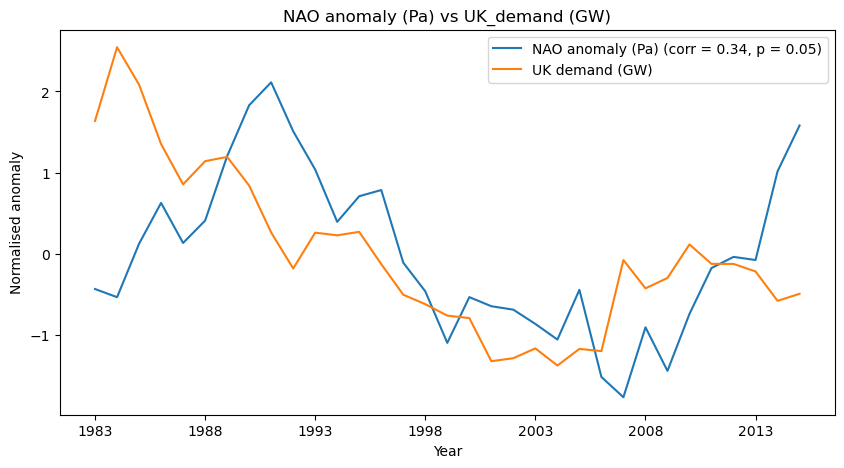

In [29]:
# Test the function
plot_corr(
    df=climate_indices_demand,
    predictor="NAO anomaly (Pa)",
    predictand="UK_demand (GW)",
    predictor_label="NAO anomaly (Pa)",
    predictand_label="UK demand (GW)",
)

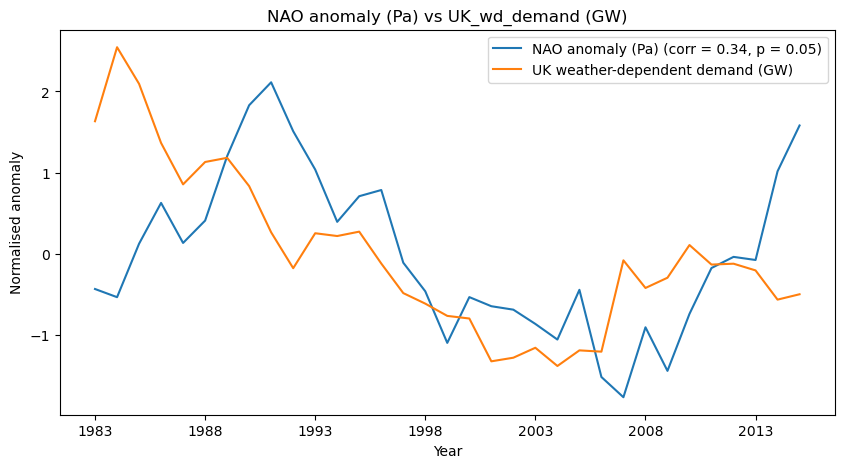

In [30]:
# Now for weathe dependent
plot_corr(
    df=climate_indices_demand,
    predictor="NAO anomaly (Pa)",
    predictand="UK_wd_demand (GW)",
    predictor_label="NAO anomaly (Pa)",
    predictand_label="UK weather-dependent demand (GW)",
)

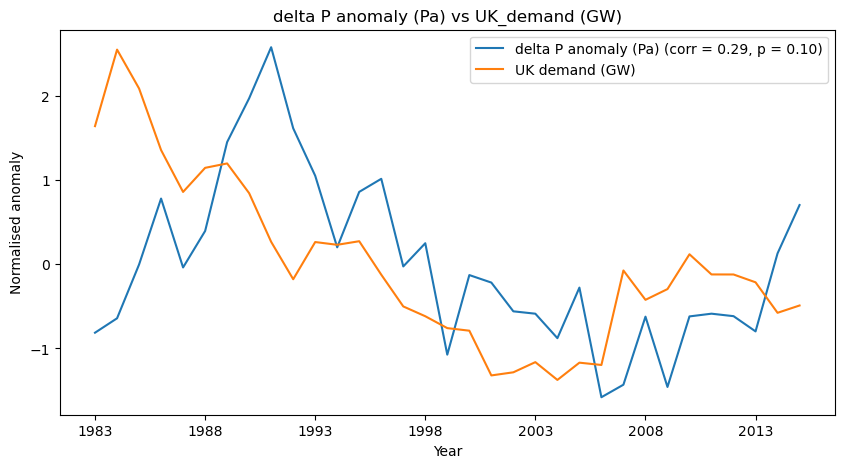

In [31]:
# Now for delta P
plot_corr(
    df=climate_indices_demand,
    predictor="delta P anomaly (Pa)",
    predictand="UK_demand (GW)",
    predictor_label="delta P anomaly (Pa)",
    predictand_label="UK demand (GW)",
)

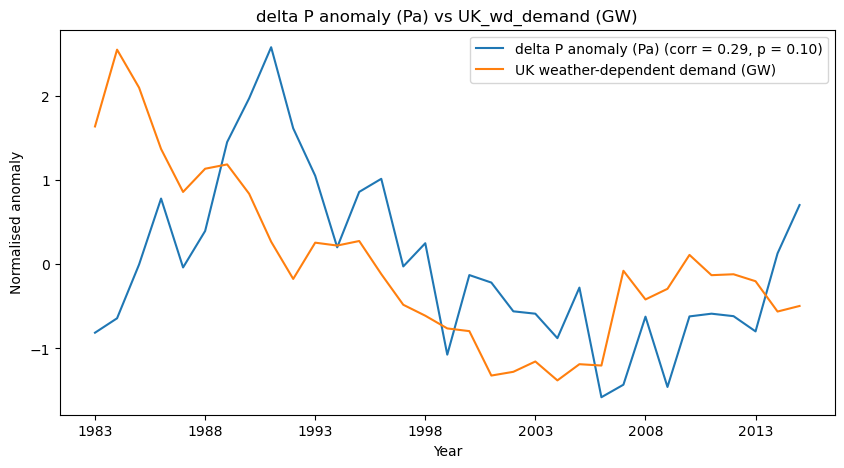

In [32]:
# And for weather dependent
plot_corr(
    df=climate_indices_demand,
    predictor="delta P anomaly (Pa)",
    predictand="UK_wd_demand (GW)",
    predictor_label="delta P anomaly (Pa)",
    predictand_label="UK weather-dependent demand (GW)",
)

detrending predictor
detrending predictand


/tmp/ipykernel_1116/3247526560.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = signal.detrend(df[predictor])
/tmp/ipykernel_1116/3247526560.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictand] = signal.detrend(df[predictand])


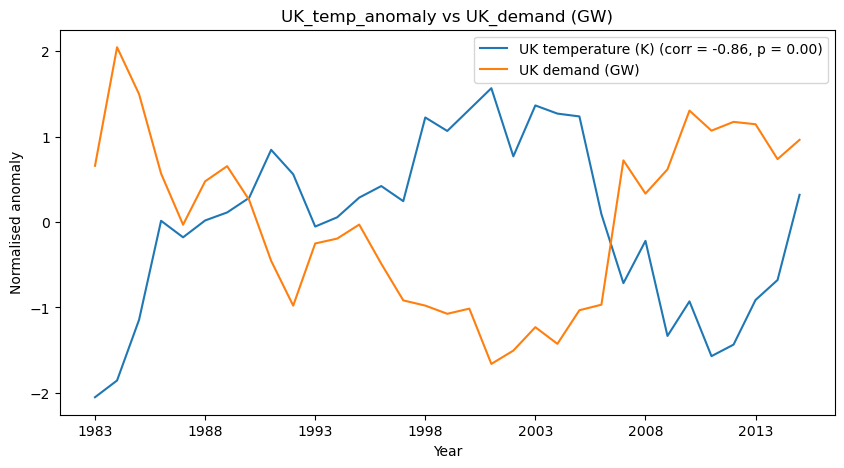

In [35]:
# Temperature and UK demand
plot_corr(
    df=climate_indices_demand,
    predictor="UK_temp_anomaly",
    predictand="UK_demand (GW)",
    predictor_label="UK temperature (K)",
    predictand_label="UK demand (GW)",
    detrend_predictor=True,
    detrend_predictand=True,
)

detrending predictor
detrending predictand


/tmp/ipykernel_1116/3247526560.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = signal.detrend(df[predictor])
/tmp/ipykernel_1116/3247526560.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictand] = signal.detrend(df[predictand])


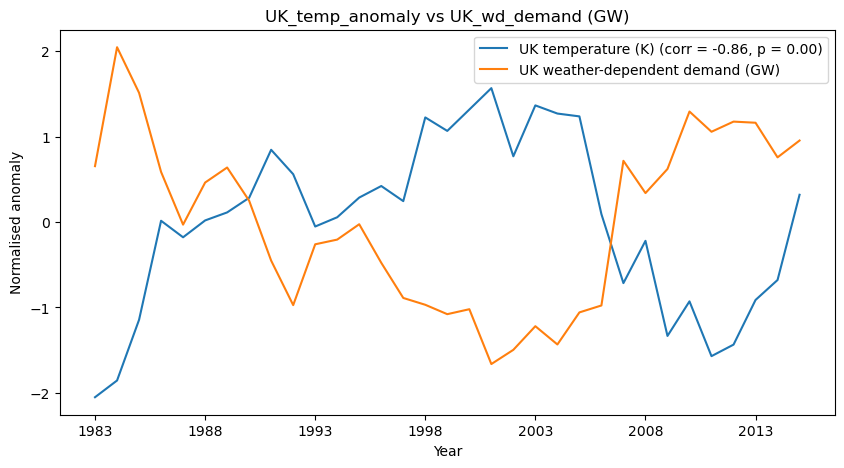

In [36]:
# Temperature and UK weather dependent demand
plot_corr(
    df=climate_indices_demand,
    predictor="UK_temp_anomaly",
    predictand="UK_wd_demand (GW)",
    predictor_label="UK temperature (K)",
    predictand_label="UK weather-dependent demand (GW)",
    detrend_predictor=True,
    detrend_predictand=True,
)